In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("all-data.csv",sep=',', encoding='latin-1',names = ["sentiment","news"])
df

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [3]:
import numpy as np

# Identify neutral sentiment reviews
neutral_reviews = df[df['sentiment'] == 'neutral']

# Determine the number of neutral reviews
num_neutral_reviews = len(neutral_reviews)

# Calculate the number of reviews to assign to each class (positive and negative)
num_reviews_per_class = num_neutral_reviews // 2

# Randomly shuffle the neutral reviews
neutral_reviews = neutral_reviews.sample(frac=1, random_state=42)

# Assign the first half of shuffled neutral reviews to positive sentiment
df.loc[neutral_reviews.iloc[:num_reviews_per_class].index, 'sentiment'] = 'positive'

# Assign the second half of shuffled neutral reviews to negative sentiment
df.loc[neutral_reviews.iloc[num_reviews_per_class:].index, 'sentiment'] = 'negative'

# Now you have distributed the neutral reviews evenly between positive and negative classes


In [4]:
df["sentiment"].value_counts()

sentiment
positive    2802
negative    2044
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

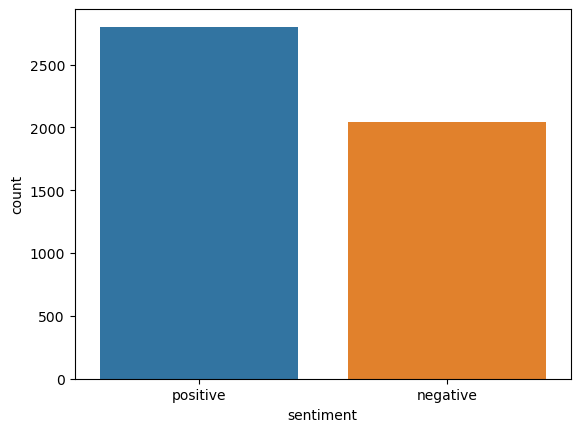

In [5]:
sns.countplot(x="sentiment",data=df)

## Exploratory Data Analysis

<Axes: xlabel='sentiment'>

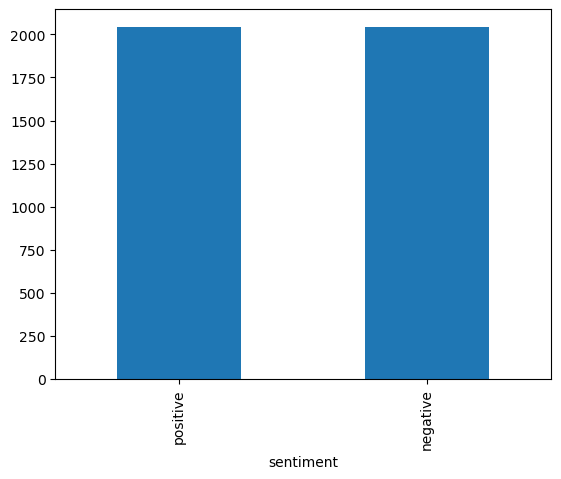

In [6]:
# Class count
count_positive, count_negative = df.sentiment.value_counts()

# Divide by class
df_positive = df[df["sentiment"] == 'positive']
df_negative = df[df["sentiment"] == 'negative']

# Sample the larger class to balance with the smaller class
df_positive_under = df_positive.sample(count_negative)

# Concatenate the balanced dataframes
df_upsampled = pd.concat([df_positive_under, df_negative], axis=0)
df_upsampled.sentiment.value_counts().plot(kind='bar')


In [7]:
df_upsampled

,sentiment,news
1911,positive,"Sami Sepp+Ænen , CEO for Elisa Eesti , says th..."
989,positive,The stock of new machines is reasonably small ...
4149,positive,"A total of 1,800,000 stock options were issued..."
182,positive,Diluted earnings per share ( EPS ) rose to EUR...
1243,positive,However short-term rentals are becoming more p...
...,...,...
4840,negative,HELSINKI Thomson Financial - Shares in Cargote...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [8]:
# Separate the two classes (positive and negative)
df_positive = df_upsampled[df_upsampled['sentiment'] == 'positive']
df_negative = df_upsampled[df_upsampled['sentiment'] == 'negative']

# Considering 80% of the data for training and 20% for testing
train_size = int(0.8 * min(len(df_positive), len(df_negative)))

# Splitting the data into training and testing sets
positive_data_points_train = df_positive.iloc[:train_size]
negative_data_points_train = df_negative.iloc[:train_size]

positive_data_points_test = df_positive.iloc[train_size:]
negative_data_points_test = df_negative.iloc[train_size:]

# Concatenate the training and test data for each class
X_train = pd.concat([positive_data_points_train["news"], negative_data_points_train["news"]])
y_train = pd.concat([positive_data_points_train["sentiment"], negative_data_points_train["sentiment"]])

X_test = pd.concat([positive_data_points_test["news"], negative_data_points_test["news"]])
y_test = pd.concat([positive_data_points_test["sentiment"], negative_data_points_test["sentiment"]])


## Pre-processing and Data Cleaning

In [9]:
def clean_news(news):
    '''
    Input:
        news: a string containing a news article.
    Output:
        news_cleaned: a processed news article. 
    '''
    temp = []
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Remove links
    news = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|''(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', news)

    # Remove HTML code
    news = re.sub('<.*?>', '', news)

    # Remove special characters, numbers, and convert to lowercase
    news = re.sub(r'[^a-zA-Z\s]', '', news).lower()

    # Tokenization
    tokens = word_tokenize(news)

    # Remove stopwords, apply lemmatization, and then apply Porter stemming
    tokens_cleaned = [ps.stem(lemmatizer.lemmatize(token)) for token in tokens if token not in stopwords.words('english')]

    news_cleaned = ' '.join(tokens_cleaned)

    return news_cleaned

In [10]:
def find_occurrence(frequency, word, label):
    '''
    Parameters:
    - frequency: a dictionary containing the frequencies of each pair (or tuple).
    - word: the word you want to find.
    - label: the label associated with the word.
    Returns:
    - n: the count of occurrences where the specified word, along with its corresponding label, appears.
    '''
    n = 0
    if (word,label) in frequency:
        n = frequency[(word,label)]
    return n

In [11]:
# Define the mapping from sentiment strings to integers
output_map = {'positive': 0, 'negative': 1}

# Use the mapping to replace sentiment labels with integers in y_train and y_test
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)


In [12]:
X_train.iloc[0]

'Sami Sepp+Ænen , CEO for Elisa Eesti , says the novel network allows fast mobile broadband for sparsely populated areas .'

In [13]:
news_ = X_train.iloc[0]

# print cleaned review
print(clean_news(news_))

sami seppnen ceo elisa eesti say novel network allow fast mobil broadband spars popul area


In [14]:
def news_counter(output_occurrence, news, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, news in zip(positive_or_negative, news):
        split_news = clean_news(news).split()
        for word in split_news:
            key = (word, label)
            if key not in output_occurrence:
                output_occurrence[key] = 0
            output_occurrence[key] += 1
    return output_occurrence

In [15]:
# Build the freqs dictionary for later uses
freqs = news_counter({}, X_train, y_train)

In [16]:
print(freqs)

{('sami', 0): 4, ('seppnen', 0): 2, ('ceo', 0): 42, ('elisa', 0): 10, ('eesti', 0): 3, ('say', 0): 24, ('novel', 0): 2, ('network', 0): 42, ('allow', 0): 6, ('fast', 0): 1, ('mobil', 0): 54, ('broadband', 0): 5, ('spars', 0): 1, ('popul', 0): 2, ('area', 0): 31, ('stock', 0): 35, ('new', 0): 88, ('machin', 0): 12, ('reason', 0): 4, ('small', 0): 6, ('order', 0): 53, ('bring', 0): 12, ('work', 0): 27, ('total', 0): 68, ('option', 0): 20, ('issu', 0): 26, ('scheme', 0): 5, ('dilut', 0): 8, ('earn', 0): 17, ('per', 0): 41, ('share', 0): 131, ('ep', 0): 19, ('rose', 0): 58, ('eur', 0): 428, ('howev', 0): 21, ('shortterm', 0): 3, ('rental', 0): 12, ('becom', 0): 9, ('popular', 0): 5, ('accord', 0): 50, ('kai', 0): 3, ('telann', 0): 1, ('compani', 0): 328, ('newspap', 0): 4, ('achiev', 0): 8, ('best', 0): 6, ('financi', 0): 48, ('result', 0): 35, ('ever', 0): 2, ('product', 0): 114, ('situat', 0): 6, ('improv', 0): 36, ('lule', 0): 1, ('municip', 0): 4, ('award', 0): 20, ('yit', 0): 11, ('ye

## Naive Bayes Classifier for Building the model

In [17]:
def train_naive_bayes(freqs, train_news, train_sentiments):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_news: a list of news articles
        train_sentiments: a list of sentiment labels correponding to the news articles (0 for positive, 1 for negative)
    Output:
        logprior: the log prior.
        loglikelihood: the log likelihood of your Naive Bayes equation.
    '''
    loglikelihood = {}
    logprior = 0

    # Calculate V, the number of unique words in the vocabulary
    vocab = set()
    for (vocab_val, label) in freqs.keys():
        vocab.add(vocab_val)
    V = len(vocab)

    # Calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    
    for pair in freqs.keys():
        # if the label is positive (0) 
        if pair[1] == 0:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]     
        # else, the label is negative (1)
        else:
            # Increment the number of negative words by the count for this (word, label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_news) 

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(train_sentiments == 0)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = sum(train_sentiments == 1)

    # Calculate logprior
    logprior =  np.log(neg_num_docs) - np.log(pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # Get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # Calculate the probability that each word is positive and negative
        p_w_pos = (1 + freq_pos) / (V + num_pos)
        p_w_neg = (1 + freq_neg) / (V + num_neg)

        # Calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_neg / p_w_pos)
        
    return logprior, loglikelihood


In [18]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
# keeping preprocessing <=0 probabliy is rounded to 0
print(len(loglikelihood))

0.0
5892


In [19]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    # process the review to get a list of words
    word_l = clean_news(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
            
    if total_prob >= 0:
        total_prob = 1
    else:
        total_prob = 0
        
    return total_prob

In [20]:
from sklearn.metrics import confusion_matrix

def test_naive_bayes(test_news, test_sentiments, logprior, loglikelihood):
    """
    Input:
        test_news: A list of news articles
        test_sentiments: the corresponding labels for the news articles (0 for positive, 1 for neutral, 2 for negative)
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of news articles classified correctly) / (total # of news articles)
    """
    accuracy = 0  
    
    y_hats = []
    for article in test_news:
        # Predict sentiment using naive_bayes_predict function
        sentiment = naive_bayes_predict(article, logprior, loglikelihood)
        
        # Classify the sentiment into 0 (positive), 1 (neutral), or 2 (negative)
        if sentiment == 0:
            y_hat_i = 0
        elif sentiment == 1:
            y_hat_i = 1
        else:
            y_hat_i = 2

        # Append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # Calculate the accuracy based on the predicted labels
    accuracy = np.mean(np.array(y_hats) == test_sentiments)

    # Print the confusion matrix and accuracy
    print(confusion_matrix(test_sentiments, y_hats))
    print(accuracy)
    
    return accuracy


In [21]:
stock_market_news = [
    "Stocks Surge to New All-Time Highs Amid Positive Earnings Reports",
    "Tech Giants Apple and Amazon Announce Strong Q3 Results",
    "Market Volatility Continues as Investors Await Federal Reserve Meeting",
    "Tesla's Electric Vehicle Sales Soar, But Supply Chain Challenges Loom",
    "Oil Prices Spike as OPEC+ Fails to Reach Production Agreement",
    "Stock Market Plummets as Economic Uncertainty Rises. Investor confidence took a hit today as the stock market experienced a significant decline. Concerns over rising inflation, supply chain disruptions, and global economic uncertainty have led to a bearish trend in the market.",
    "Market Analysts Assess Impact of Recent Policy Changes. Market analysts are closely monitoring the effects of recent policy changes on stock prices. While some experts believe the changes may have a neutral impact, others are cautiously optimistic about potential positive outcomes for certain sectors."
]

for news in stock_market_news:
    sentiment = naive_bayes_predict(news, logprior, loglikelihood)
    print(f'News Article: {news} -> Predicted Sentiment: {sentiment}')


News Article: Stocks Surge to New All-Time Highs Amid Positive Earnings Reports -> Predicted Sentiment: 0
News Article: Tech Giants Apple and Amazon Announce Strong Q3 Results -> Predicted Sentiment: 1
News Article: Market Volatility Continues as Investors Await Federal Reserve Meeting -> Predicted Sentiment: 0
News Article: Tesla's Electric Vehicle Sales Soar, But Supply Chain Challenges Loom -> Predicted Sentiment: 0
News Article: Oil Prices Spike as OPEC+ Fails to Reach Production Agreement -> Predicted Sentiment: 0
News Article: Stock Market Plummets as Economic Uncertainty Rises. Investor confidence took a hit today as the stock market experienced a significant decline. Concerns over rising inflation, supply chain disruptions, and global economic uncertainty have led to a bearish trend in the market. -> Predicted Sentiment: 1
News Article: Market Analysts Assess Impact of Recent Policy Changes. Market analysts are closely monitoring the effects of recent policy changes on stock pr

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

X_train, X_test, Y_train, Y_test = train_test_split(df_upsampled['news'], df_upsampled['sentiment'], test_size=0.2)

output_map = {'positive': 0, 'negative': 1}
y_train = Y_train.map(output_map)
y_test = Y_test.map(output_map)
freqs = news_counter({}, X_train, y_train)

logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

-0.013455860515391826
5800


In [23]:
from sklearn.metrics import confusion_matrix
# 3. printing out the confusion matrix for the train set
print("Confusion matrix for training set:")
acc1 = test_naive_bayes(X_train, y_train, logprior, loglikelihood)

Confusion matrix for training set:
[[1411  235]
 [ 209 1415]]
0.8642201834862385


In [24]:
# 3. printing out the confusion matrix for the test set
print("Confusion matrix for test set:")
acc2 = test_naive_bayes(X_test, y_test, logprior, loglikelihood)

Confusion matrix for test set:
[[242 156]
 [171 249]]
0.6002444987775061
